# Using PyMC3 to fit a Linear Regression Model

Ram Narasimhan

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pymc3 as pm


In [33]:
MARINEBLUE = True


if MARINEBLUE:
    df = pd.read_csv('data/marineblue_sales.csv')
    df.rename(columns={'BEDS':'bdrms', 'SOLD PRICE': 'price'}, inplace=True)
else:
    df = pd.read_csv('data/Pallavaram_home_prices.csv')

    
df.head()

,UNIT,price,bdrms,BATHS,SQFT,FURNISHED,MAINT$,SOLD DATE
0,2909,470000,2,2.5,1323,NO,800.0,12/16/2019
1,5005,515000,2,2.0,1200,NO,789.0,12/2/2019
2,706,548500,2,2.5,1457,NO,950.0,9/20/2019
3,4703,385000,1,1.5,943,NO,620.0,9/18/2019
4,2412,459000,2,2.0,1318,NO,823.0,9/5/2019


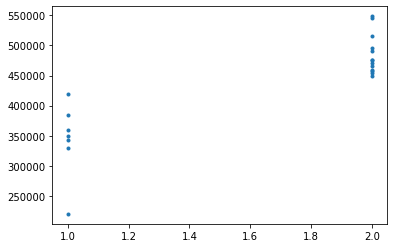

In [34]:
plt.plot(df['bdrms'], df['price'], '.')

As the plot above shows, it is not easy to "draw a line of best fit.' The prices are scattered for each of the 3 distinct bedroom counts. We could try and fit a linear regression model. But perhaps, a Bayesian model is even more relevant here. We want to understand the *range* of certain parameters.

In [35]:
df['bdrms'].values

array([2, 2, 2, 1, 2, 1, 2, 2, 2, 1, 1, 2, 1, 2, 2, 2, 2, 1, 2, 1],
      dtype=int64)

In [44]:
bdrms = df['bdrms'].values
actual_prices = df['price'].values

if MARINEBLUE:
    MAX_BASE = 500000
    MAX_PPB = 400000
    MAX_SD = 200000
else:
    MAX_BASE = 50
    MAX_PPB = 50
    MAX_SD = 10
    
with pm.Model() as home_price_model:
    
    #define priors
    c = pm.Uniform('base_price', 0, MAX_BASE) # This is the price for a home with ZERO bedrooms
    m = pm.Uniform('per_bdrm_cost', 0, MAX_PPB) #Additional cost for each bedroom 
    sigma = pm.HalfNormal('sigma', sd=MAX_SD)

    y_predicted = m * bdrms + c 
    
    #define Likelihood
    likelihood = pm.Normal('y',
                           mu = y_predicted, sigma = sigma,
                           observed = actual_prices)
        

In [45]:
home_price_model

In [46]:
len(actual_prices) # Number of observations we have

20

# Ready to Start Sampling

We are going to sample (draw from) 10,000 times. Each attempt will get us one set of (m, x, and sigma).
If the error is "acceptable," we will randomly sample more in that neighborhood of m, x and sigam.
If the error is large, we will 'jump' elsewhere and try sampling there.
Note: the first 1000 values will be discarded. They are to warm-up the model.

In [48]:
with home_price_model:
    trace = pm.sample(10000, 
                      chains=2,
                      tune=5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [per_bdrm_cost, base_price, sigma]
Sampling 2 chains, 0 divergences: 100%|█████████████████████████████████████████| 30000/30000 [00:30<00:00, 983.62draws/s]
The acceptance probability does not match the target. It is 0.8820716373486259, but should be close to 0.8. Try to increase the number of tuning steps.


In [49]:
pm.summary(trace).round(2)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
sigma,48322.07,8920.38,32814.87,64427.19,108.75,77.27,6729.0,6664.0,6835.0,7101.0,1.0
base_price,202845.49,39964.53,126380.90,276608.47,516.57,367.05,5985.0,5928.0,6057.0,6497.0,1.0
per_bdrm_cost,140891.53,23253.38,96558.88,184691.87,298.10,210.80,6085.0,6085.0,6146.0,7030.0,1.0


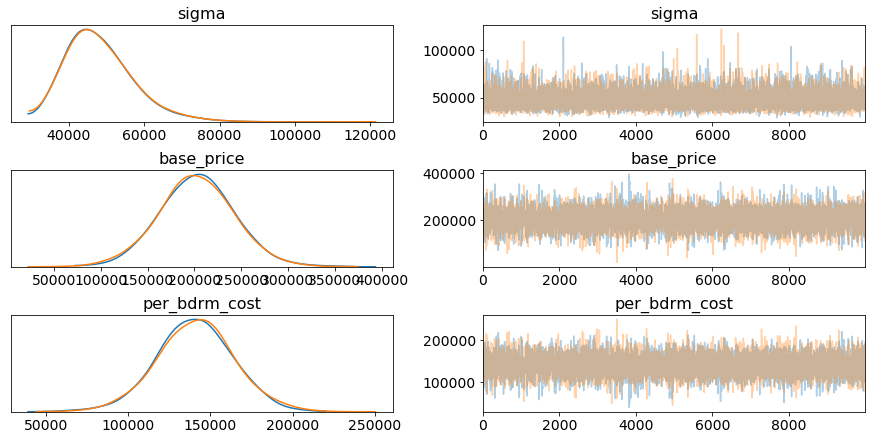

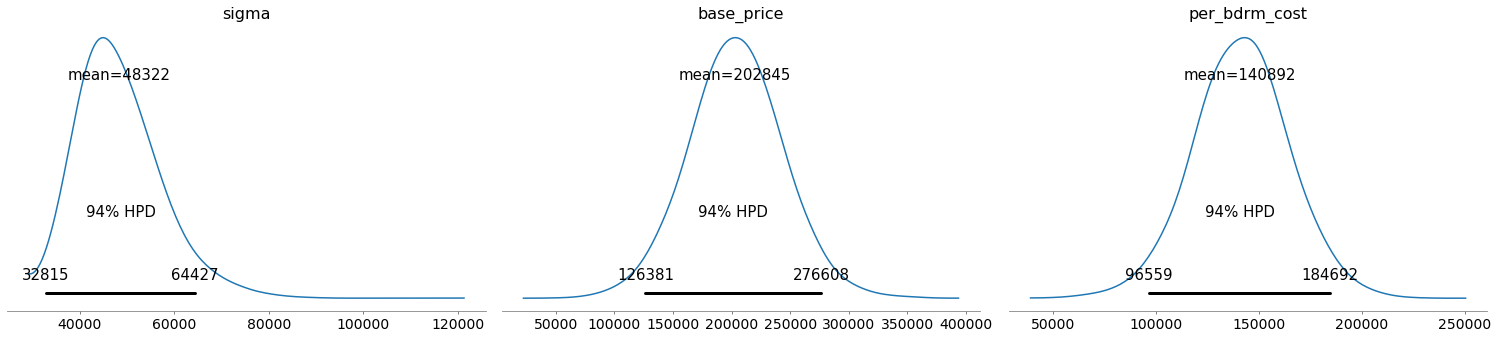

In [50]:
pm.traceplot(trace);
axes = pm.plot_posterior(trace)

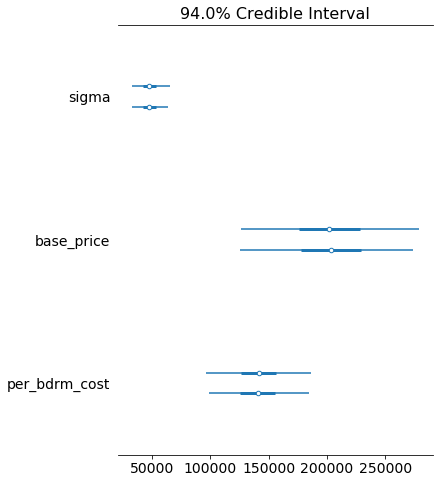

In [51]:
pm.forestplot(trace);

### Peek inside Trace

It is perfectly okay to look under the hood.

In [16]:
len(trace)

10000

In [17]:
trace[4319]

{'sigma_log__': 3.110761496656329,
 'base_price_interval__': 3.245631069213459,
 'per_bdrm_cost_interval__': 2.9017310142472157,
 'sigma': 22.438124453465075,
 'base_price': 48.12579017761585,
 'per_bdrm_cost': 9.479319408272818}

So trace is a List.
It is a list of dictionaries.
It is a list of 10,000 dictionaries

(array([ 3.,  5., 11., 11., 20., 14., 19.,  9.,  4.,  4.]),
 array([ 77165.66870045,  88905.23245577, 100644.7962111 , 112384.35996642,
        124123.92372175, 135863.48747708, 147603.0512324 , 159342.61498773,
        171082.17874305, 182821.74249838, 194561.3062537 ]),
 <a list of 10 Patch objects>)

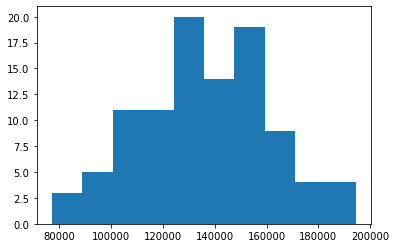

In [56]:
plt.hist([x['per_bdrm_cost'] for x in trace[9900:]])